# Importation des libraries

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd 
import random
import math
from scipy.stats import expon
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from pandas import read_csv
from pandas.plotting import autocorrelation_plot
import scipy.optimize as optim

#from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn')
%matplotlib inline 


# Lecture et Preparation des donnees

Nous proposons une modelisation des cas confirmes par jour et des cas confirmes cumulatif

In [3]:
df = pd.read_csv("dailycasenumber_oa.csv",sep=",")
df.columns


Index(['Country', 'Lat', 'Long', 'Date', 'Confirmed_cases', 'Dead',
       'Recovered', 'Daily_case'],
      dtype='object')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 8 columns):
Country            1110 non-null object
Lat                1110 non-null float64
Long               1110 non-null float64
Date               1110 non-null datetime64[ns]
Confirmed_cases    1110 non-null int64
Dead               1110 non-null int64
Recovered          1110 non-null int64
Daily_case         1110 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 69.5+ KB


In [5]:
df.head()

,Country,Lat,Long,Date,Confirmed_cases,Dead,Recovered,Daily_case
0,Burkina Faso,12.2383,-1.5616,2020-01-22,0,0,0,0
1,Burkina Faso,12.2383,-1.5616,2020-01-23,0,0,0,0
2,Burkina Faso,12.2383,-1.5616,2020-01-24,0,0,0,0
3,Burkina Faso,12.2383,-1.5616,2020-01-25,0,0,0,0
4,Burkina Faso,12.2383,-1.5616,2020-01-26,0,0,0,0


In [6]:
file_name = 'Covid19SN_datas_country.xlsx' 
df_senegal = pd.read_excel(file_name, index_col=0)
df_senegal.shape
df_senegal = df_senegal.reset_index()
df_senegal['Date'] = pd.to_datetime(df_senegal['Date'])
df_senegal.head()




,Country,lat,long,Date,Daily_case,Confirmed_cases,Recovered,Dead
0,Senegal,14.497400,-14.452400,2020-03-02,1,1,0,0
1,Senegal,14.497401,-14.452401,2020-03-03,1,2,0,0
2,Senegal,14.497402,-14.452402,2020-03-04,2,4,0,0
3,Senegal,14.497403,-14.452403,2020-03-05,0,4,0,0
4,Senegal,14.497404,-14.452404,2020-03-06,0,4,1,0


In [7]:
countries = df['Country'].unique()

# Modelisation 

In [8]:
def get_daily_var(ct,df):
    
    """
      This function takes the countries name and database in parameters.
      It returns a datframe with daily cases value and date as index
    """
    #Prepare country data
    ct_df = df[df['Country'] == ct]
    first_date = ct_df[ct_df['Confirmed_cases'] != 0]['Date'].values[0]
    confirmed = ct_df[ct_df['Date'] >= first_date]
    confirmed_cases = confirmed[['Date', 'Daily_case']].set_index('Date')
    
    
    return confirmed_cases

##  Preparation des donnees

In [9]:
def get_pred_data (conf):
          
    """
      This function takes the daily dataframe and return it as arrays value
      for modelling purpose
    """
    #rearange dataframe values in array format
    cases_daily = np.array(conf).reshape(-1,1)
    cases_cum = np.array(conf.cumsum()).reshape(-1,1)
    days_since = np.arange(len(conf)).reshape(-1,1)
    
    return  cases_daily, cases_cum, days_since


### Temps predictif

In [10]:
def get_pred_date (n, conf):
    
    """
      This function generates n days for prediction
    """
    future_forcast = np.arange(len(conf) + n).reshape(-1,1)
    start_date = conf.index[0]
    future_forcast_dates = [(start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y') for i in range(len(future_forcast))] 
    
    return future_forcast,future_forcast_dates

# Bayesian Ridge

la régression linéaire bayésien est une méthode de régression linéaire dans laquelle 
l'analyse statistique est réalisée dans le cadre de l'inférence bayésienne . 
Lorsque le modèle de régression a des erreurs qui ont une distribution normale , 
et si une forme particulière de la distribution préalable suppose, les résultats explicites sont disponibles
pour les distributions de probabilité postérieure des paramètres du modèle.

https://fr.qwe.wiki/wiki/Bayesian_linear_regression

In [11]:
def bayes_model(ct, df, n, mode = 'normal', plot = False):
    
    """
      This function defines init and run the bayesian model
    """
     
    cases_df = get_daily_var(ct,df)   
    cases_daily, cases_cum, days_since = get_pred_data(cases_df)
    future_forcast,future_forcast_dates = get_pred_date(n, cases_df)
    
    # bayesian ridge (Init and fit)
    tol = [1e-4, 1e-3, 1e-2]
    alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
    alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
    lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
    lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

    bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

    bayesian = BayesianRidge(compute_score=True)
    bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)

    if mode == 'normal':
        cases = cases_daily
        X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(days_since, cases, test_size=0.25, shuffle=False)  
        bayesian_search.fit(X_train_daily, y_train_daily)
        bayesian_daily_params = bayesian_search.best_estimator_
        bayesian_pred = bayesian_daily_params.predict(X_test_daily)
        print('MAE:', mean_absolute_error(bayesian_pred, y_test_daily))
        print('MSE:',mean_squared_error(bayesian_pred, y_test_daily))
        bayesian_pred_future = bayesian_daily_params.predict(future_forcast)       
       
          
    if mode == 'cum':
        cases = cases_cum
        X_train_cum, X_test_cum, y_train_cum, y_test_cum = train_test_split(days_since, cases, test_size=0.25, shuffle=False)  
        bayesian_search.fit(X_train_cum, y_train_cum)
        bayesian_cum_params = bayesian_search.best_estimator_
        bayesian_pred = bayesian_cum_params.predict(X_test_cum)
        print('MAE:', mean_absolute_error(bayesian_pred, y_test_cum))
        print('MSE:',mean_squared_error(bayesian_pred, y_test_cum))
        bayesian_pred_future = bayesian_cum_params.predict(future_forcast)       
        


        
    if plot == True:
        plt.figure(figsize=(20, 12))
        plt.plot(future_forcast_dates[:-n], cases)
        plt.plot(future_forcast_dates, bayesian_pred_future, linestyle='dashed', color='green')
        plt.title(f'Nombre de cas confirmes au {ct} en fonction du temps', size=30)
        plt.xlabel('Temps', size=30)
        plt.ylabel('Nombre de cas', size=30)
        plt.legend(['Cas Confirmes', 'Bayesian Ridge Regression Predictions'], prop={'size': 20})
        plt.xticks(size=20, rotation= 90)
        plt.yticks(size=20)
        plt.show()   
        
    # Future predictions using Linear Regression 
    print('bayesian model future predictions:')
    zipped =zip(future_forcast_dates, np.round(bayesian_pred_future) )
    # Converting to list 
    zipped = list(zipped) 
      # Using sorted and lambda 
    res = sorted(zipped, key = lambda x: x[1]) 
      # printing result 
    df_result = pd.DataFrame(res)
    df_result.columns=('Date','Predictions')
    print(df_result.tail(n))
    
    
        


        
    return None

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.3s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 75.35300279591624
MSE: 6207.134724010059


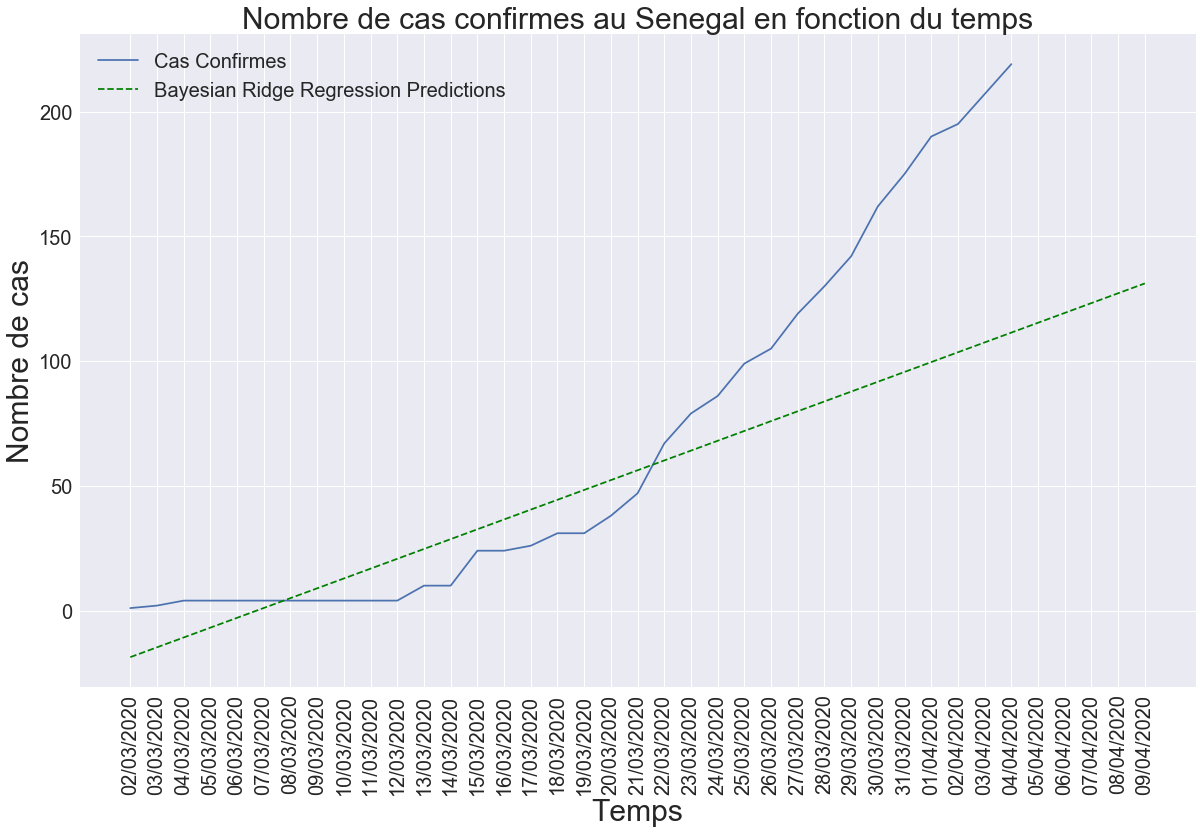

bayesian model future predictions:
          Date  Predictions
34  05/04/2020        115.0
35  06/04/2020        119.0
36  07/04/2020        123.0
37  08/04/2020        127.0
38  09/04/2020        131.0


In [12]:
bayes_model('Senegal', df, n=5, mode = 'cum', plot = True)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
MAE: 3.0928315306204768
MSE: 17.977518889287307


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


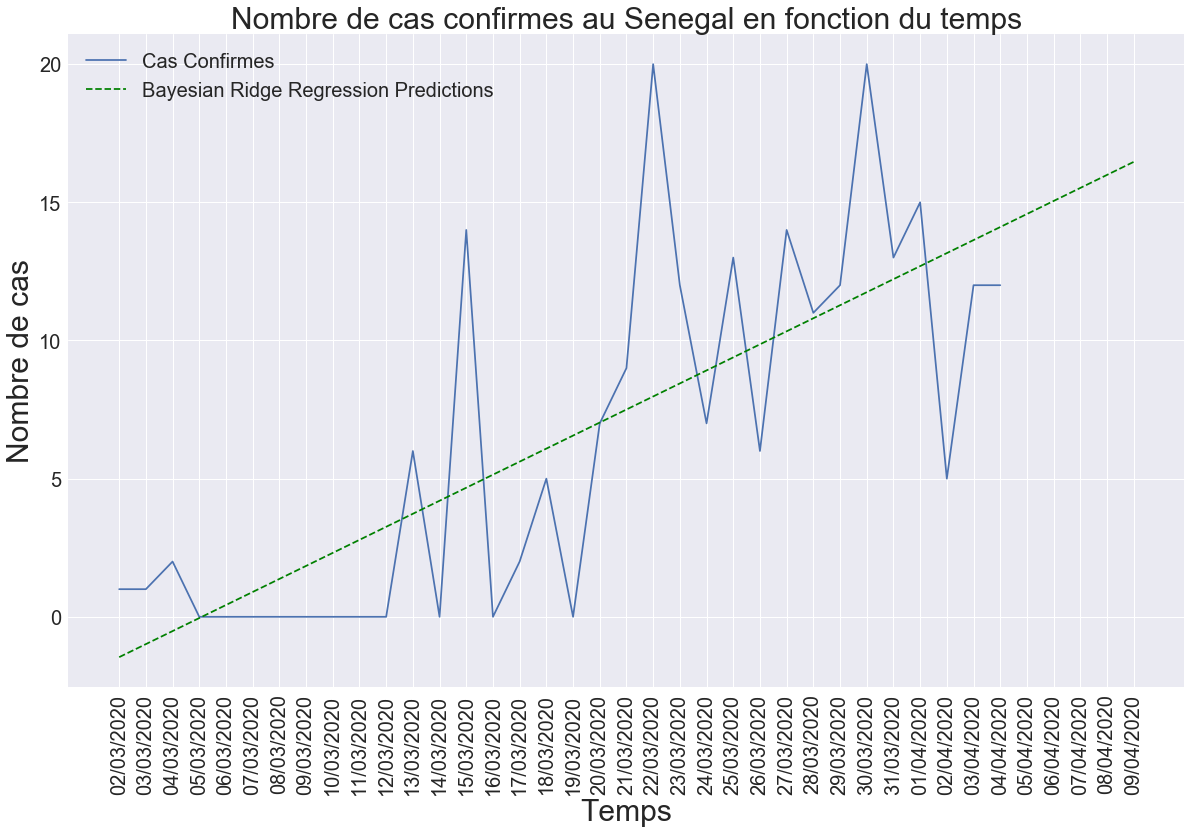

bayesian model future predictions:
          Date  Predictions
34  05/04/2020         15.0
35  06/04/2020         15.0
36  07/04/2020         16.0
37  08/04/2020         16.0
38  09/04/2020         16.0


In [13]:
bayes_model('Senegal', df, n=5, mode = 'normal', plot = True)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
MAE: 3.9543159340834606
MSE: 31.39312021512699


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


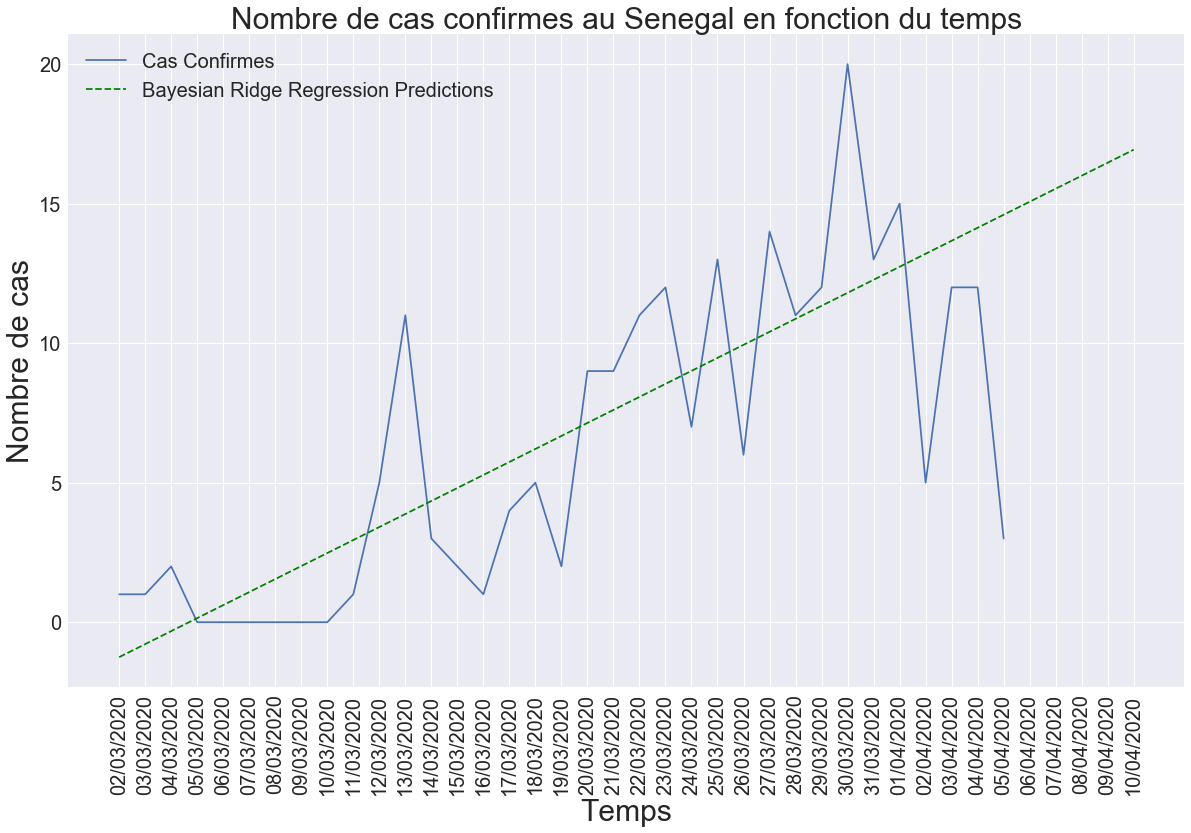

bayesian model future predictions:
          Date  Predictions
35  06/04/2020         15.0
36  07/04/2020         16.0
37  08/04/2020         16.0
38  09/04/2020         16.0
39  10/04/2020         17.0


In [14]:
bayes_model('Senegal', df_senegal, n=5, mode = 'normal', plot = True)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
MAE: 70.96599835693877
MSE: 5427.4297176334685


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


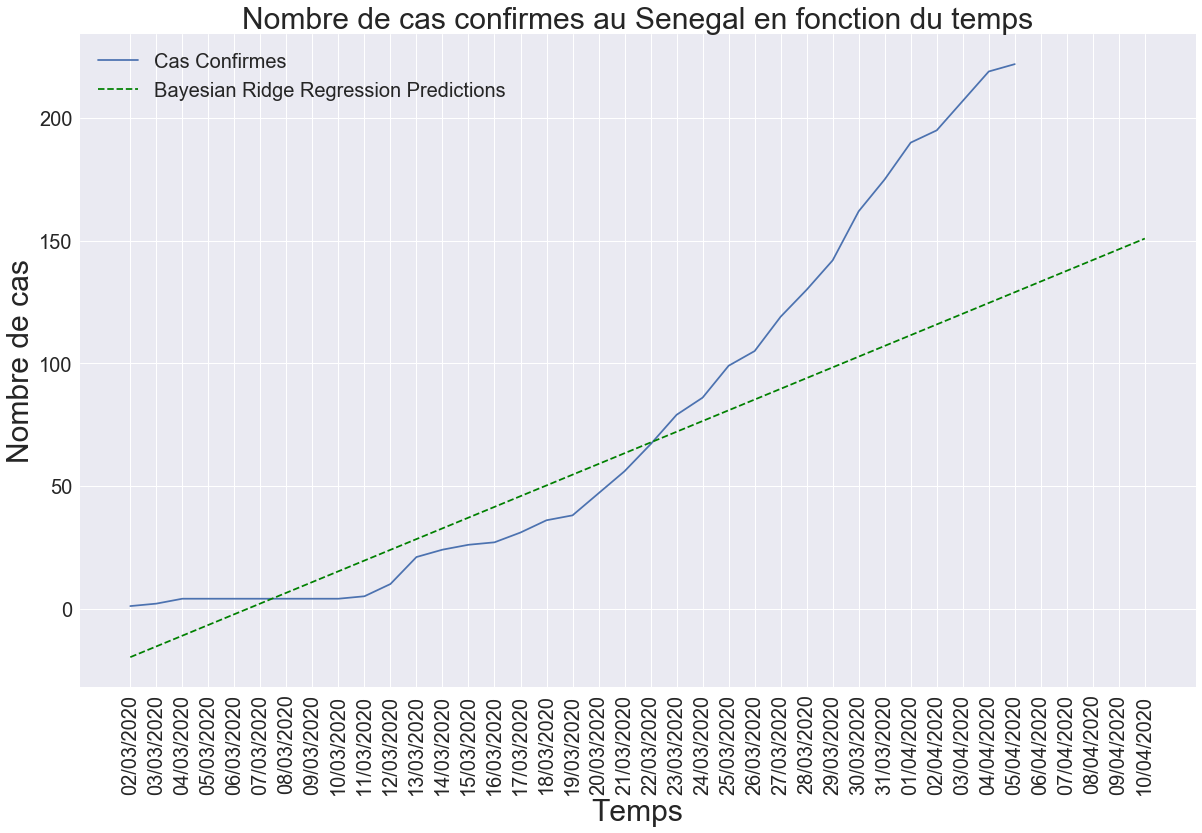

bayesian model future predictions:
          Date  Predictions
35  06/04/2020        133.0
36  07/04/2020        138.0
37  08/04/2020        142.0
38  09/04/2020        146.0
39  10/04/2020        151.0


In [15]:
bayes_model('Senegal', df_senegal, n=5, mode = 'cum', plot = True)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
MAE: 3.9543166189032126
MSE: 31.393277781085267


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


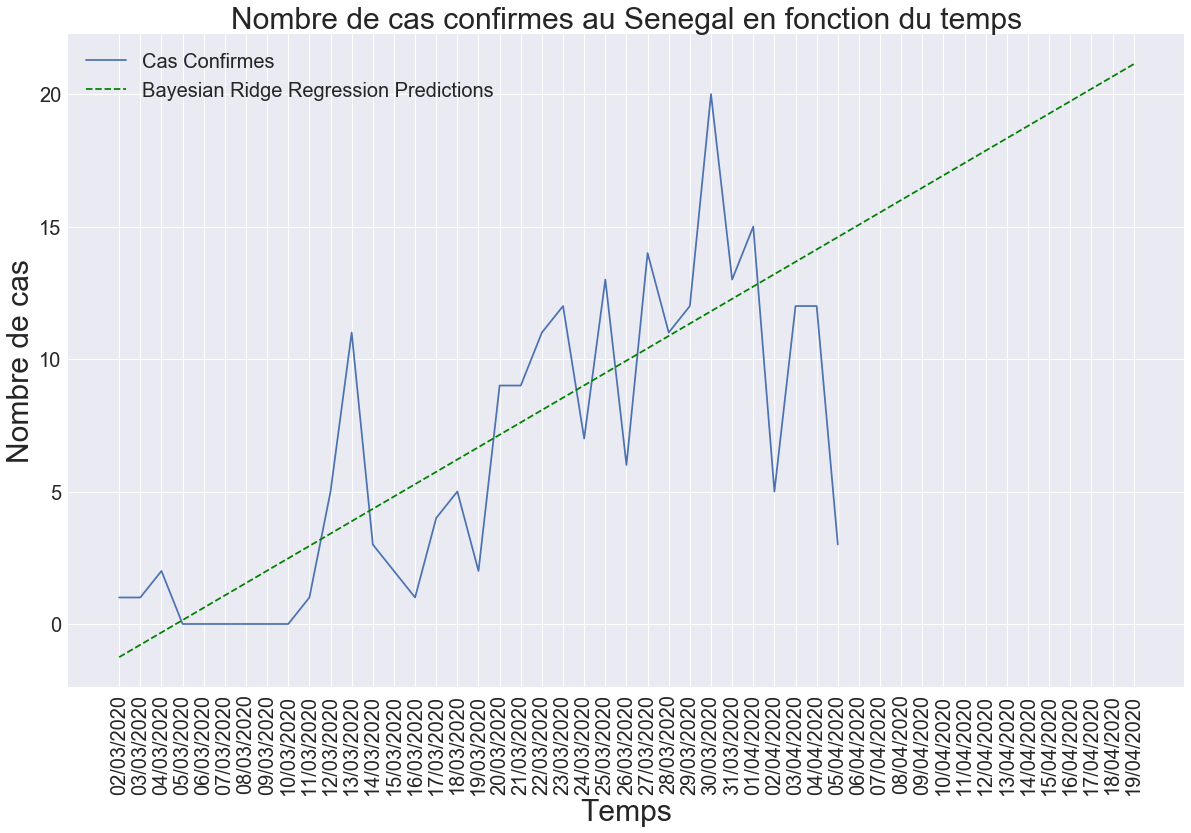

bayesian model future predictions:
          Date  Predictions
35  06/04/2020         15.0
36  07/04/2020         16.0
37  08/04/2020         16.0
38  09/04/2020         16.0
39  10/04/2020         17.0
40  11/04/2020         17.0
41  12/04/2020         18.0
42  13/04/2020         18.0
43  14/04/2020         19.0
44  15/04/2020         19.0
45  16/04/2020         20.0
46  17/04/2020         20.0
47  18/04/2020         21.0
48  19/04/2020         21.0


In [16]:
bayes_model('Senegal', df_senegal, n=14, mode = 'normal', plot = True)

# Polynomial Regression

In [17]:

def polynom_regression_model(ct, df, n=5, p=2, plot = False):
    """
      This function defines init and run the polynomial regression model
    """
    #Data prep
    cases_df = get_daily_var(ct,df)   
    _, cases_cum, days_since = get_pred_data(cases_df)
    future_forcast,future_forcast_dates = get_pred_date(n, cases_df)
    poly = PolynomialFeatures(degree = p)
    
    #Split Data
    X_train_cum, X_test_cum, y_train_cum, y_test_cum = train_test_split(days_since, cases_cum, test_size=0.25, shuffle=False)
    
    #fit and init model                                                                   
    X_poly = poly.fit_transform(X_train_cum)
    poly.fit(X_poly, y_train_cum)
    lin2 = LinearRegression()
    lin2.fit(X_poly, y_train_cum)
    cum_poly_pred_future = lin2.predict(poly.fit_transform(future_forcast))
                                                                        
    #ploting_results
    if plot == True:
                                                                        
        plt.figure(figsize=(20, 12))
        plt.plot(future_forcast_dates[:-n], cases_cum, color='blue')
        plt.plot(future_forcast_dates, cum_poly_pred_future, linestyle='dashed', color='green')
        plt.title(f'Nombre de cas confirmes au {ct} en fonction du temps', size=30)
        plt.xlabel('Temps', size=20)
        plt.ylabel('Nombre de cas', size=30)
        plt.legend(['Cas Confirmes', 'polynomial Regression Predictions'], prop={'size': 30})
        plt.xticks(size=20, rotation = 90)
        plt.yticks(size=20)
        plt.show() 
        
  # Future predictions using Linear Regression 
    print('Polynomial future predictions:')
    zipped =zip(future_forcast_dates, np.round(cum_poly_pred_future) )
    # Converting to list 
    zipped = list(zipped) 
      # Using sorted and lambda 
    res = sorted(zipped, key = lambda x: x[1]) 
      # printing result 
    df_result = pd.DataFrame(res)
    df_result.columns=('Date','Predictions')
    print(df_result.tail(n))      
                                                                        
    return None

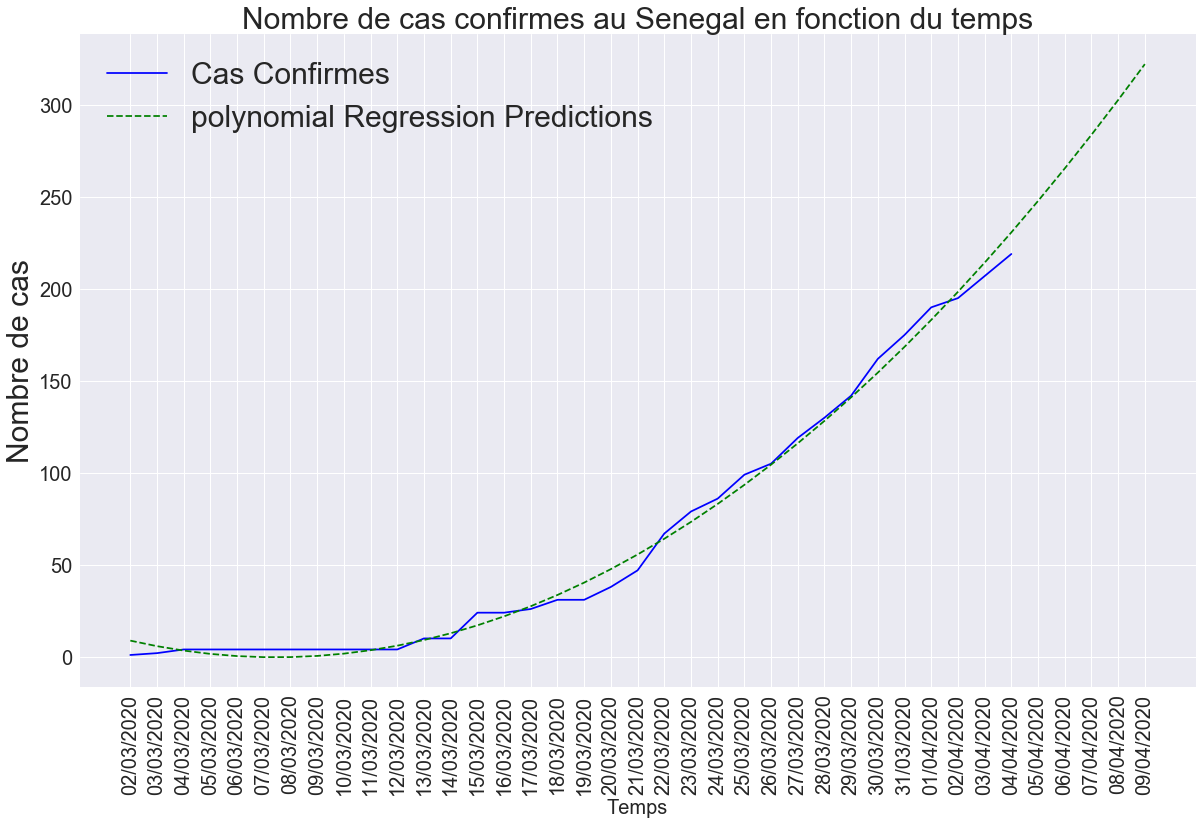

Polynomial future predictions:
          Date Predictions
34  05/04/2020     [248.0]
35  06/04/2020     [266.0]
36  07/04/2020     [284.0]
37  08/04/2020     [303.0]
38  09/04/2020     [322.0]


In [18]:
polynom_regression_model('Senegal', df, n=5, p=2, plot = True)

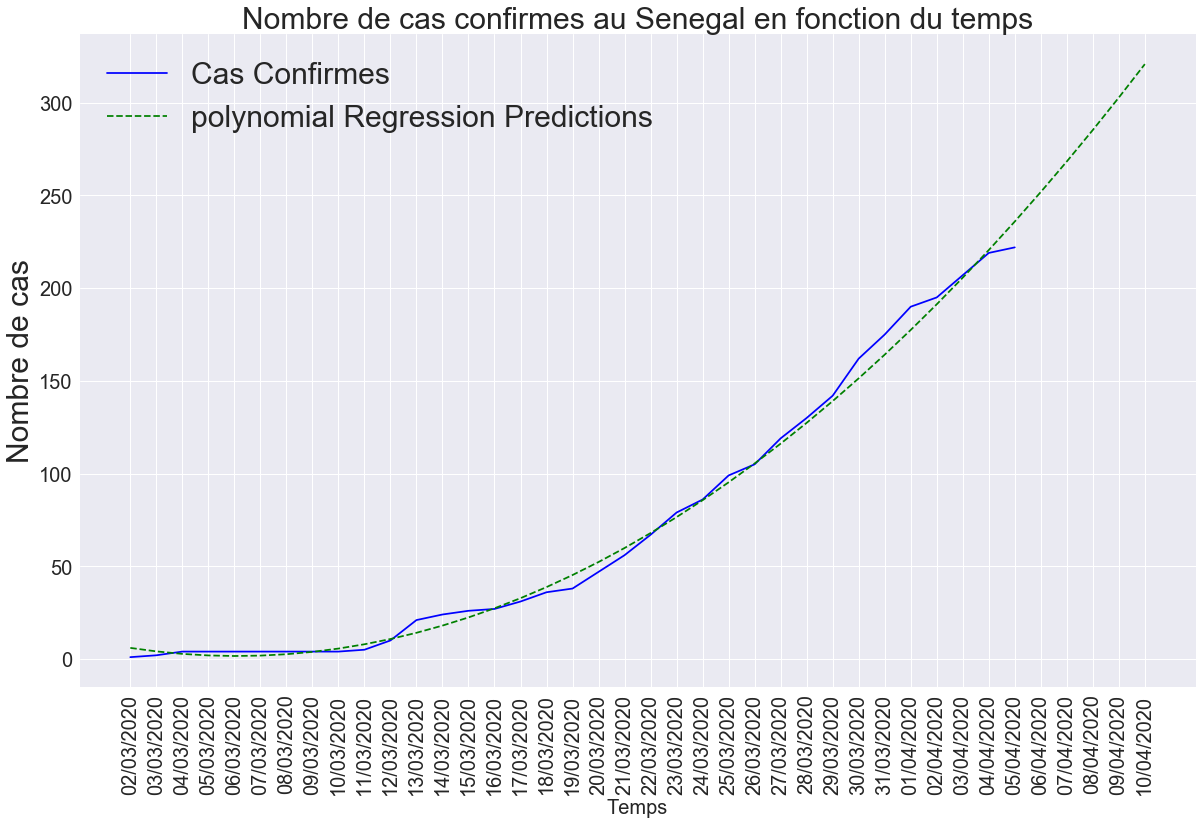

Polynomial future predictions:
          Date Predictions
35  06/04/2020     [252.0]
36  07/04/2020     [268.0]
37  08/04/2020     [285.0]
38  09/04/2020     [303.0]
39  10/04/2020     [321.0]


In [19]:
polynom_regression_model('Senegal', df_senegal, n=5, p=2, plot = True)

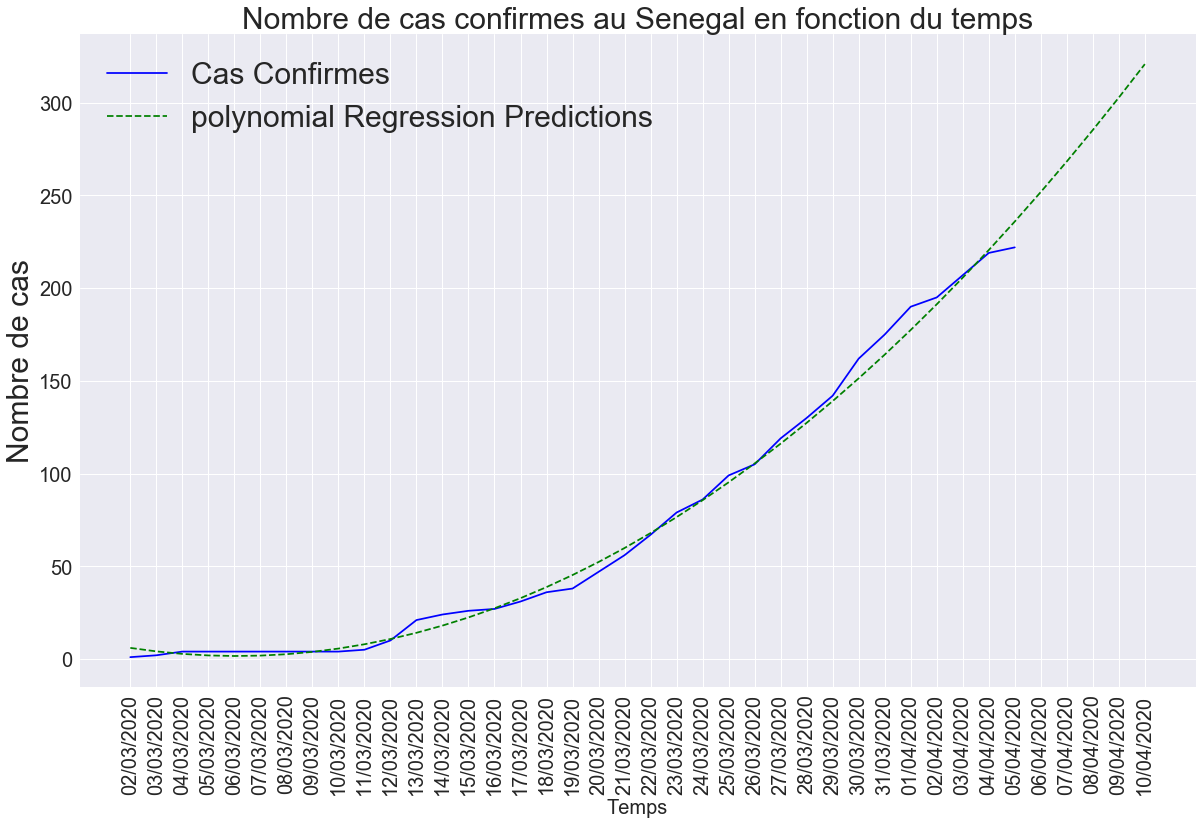

Polynomial future predictions:
          Date Predictions
35  06/04/2020     [252.0]
36  07/04/2020     [268.0]
37  08/04/2020     [285.0]
38  09/04/2020     [303.0]
39  10/04/2020     [321.0]


In [20]:
polynom_regression_model('Senegal', df_senegal, n=5, p=2, plot = True)

# Modeling Logistic Growth

Reference

https://jooskorstanje.com/modeling-logistic-growth-corona.html
https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f
https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f
https://towardsdatascience.com/modeling-logistic-growth-1367dc971de2


La croissance logistique est une fonction mathématique qui peut être utilisée dans plusieurs situations. La croissance logistique se caractérise par une croissance croissante au début, mais une croissance décroissante à un stade ultérieur, à mesure que l'on se rapproche d'un maximum. Par exemple, dans le cas du coronavirus, cette limite maximale serait le nombre total de personnes dans le monde, car lorsque tout le monde est malade, la croissance diminuera nécessairement.
Dans d'autres cas d'utilisation de croissance logistique, ce nombre pourrait être la taille d'une population animale qui croît de façon exponentielle jusqu'au moment où leur environnement ne fournit pas suffisamment de nourriture pour tous les animaux et donc la croissance devient plus lente jusqu'à ce qu'une capacité maximale de l'environnement soit atteinte .
La raison d'utiliser la croissance logistique pour modéliser l'épidémie de coronavirus est que les épidémiologistes ont étudié ces types d'épidémies et il est bien connu que la première période d'une épidémie suit la croissance exponentielle et que la période totale peut être modélisée avec une croissance logistique.

In [21]:
def logistic_growth_model(ct, df, n=5, size = 3):
    
    cases_df = get_daily_var(ct,df)
    future_forcast,future_forcast_dates = get_pred_date(n, cases_df)
    
    # Define funcion with the coefficients to estimate
    def my_logistic(t, a, b, c):
        return c / (1 + a * np.exp(-b*t))
    
    #Randomly initialize the coefficients
    p0 = np.random.exponential(size=3)
    
    # Set min bound 0 on all coefficients, and set different max bounds for each coefficient
    bounds = (0, [100, 3., 1000])
    
    # Convert pd.Series to np.Array and use Scipy's curve fit to find the best Nonlinear Least Squares coefficients
    x = np.arange(len(cases_df)) + 1
    y = np.array(cases_df.cumsum()['Daily_case'])
    
    (a,b,c),cov = optim.curve_fit(my_logistic, x, y, bounds=bounds, p0=p0)
    
    # Redefine the function with the new a, b and c
    def my_logistic(t):
        return c / (1 + a * np.exp(-b*t))
    plt.figure(figsize=(20,12))
    plt.scatter(future_forcast_dates[0:len(y)], y)
    plt.plot(x, my_logistic(x),color = 'red')
    plt.title('Logistic Model vs Real Observations of Senegal Coronavirus')
    plt.legend([ 'Logistic Model', 'Real data'])
    plt.xlabel('Time')
    plt.ylabel('Infections')
    plt.xticks(rotation = 90)
    plt.show()
    
    plt.figure(figsize=(20,12))
    plt.scatter(x, y)
    plt.plot(future_forcast_dates, my_logistic(future_forcast),color = 'red')
    plt.title(f'Logistic Model vs Real Observations of {ct} Coronavirus')
    plt.legend([' Predict Logistic Model ', 'Real data'])
    plt.xlabel('Time')
    plt.ylabel('Infections')
    plt.xticks(rotation = 90)
    plt.show()
    
    # The time step at which the growth is fastest
    t_fastest = np.log(a) / b
    t_fastest
    print(np.round(t_fastest))
    future_forcast_dates[27]
    # First way to find the y of the fastest growth moment
    y_fastest = c / 2
    y_fastest
    # Second way to find the y of the fastest growth moment
    print(my_logistic(t_fastest))  
    
    # Future predictions using Linear Regression 
    print('logistic future predictions:')
    zipped =zip(future_forcast_dates, np.round(my_logistic(future_forcast)) )
    # Converting to list 
    zipped = list(zipped) 
      # Using sorted and lambda 
    res = sorted(zipped, key = lambda x: x[1]) 
      # printing result 
    df_result = pd.DataFrame(res)
    df_result.columns=('Date','Predictions')
    print(df_result.tail(n)) 
    
    return None

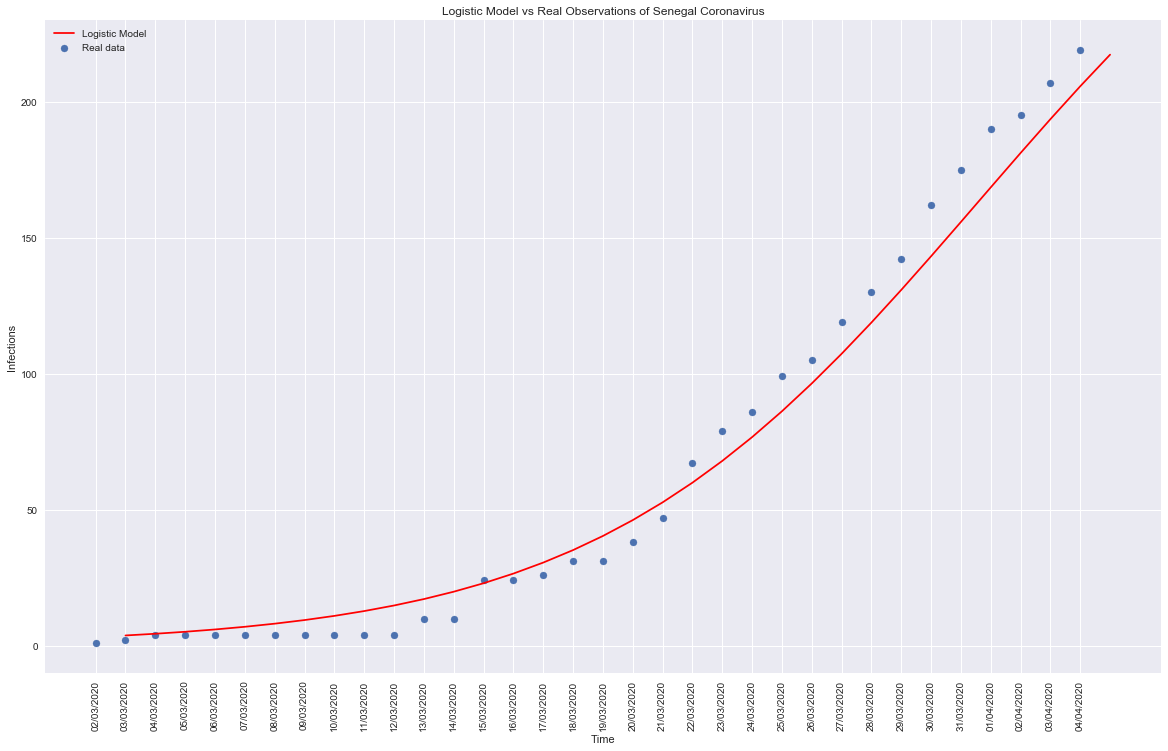

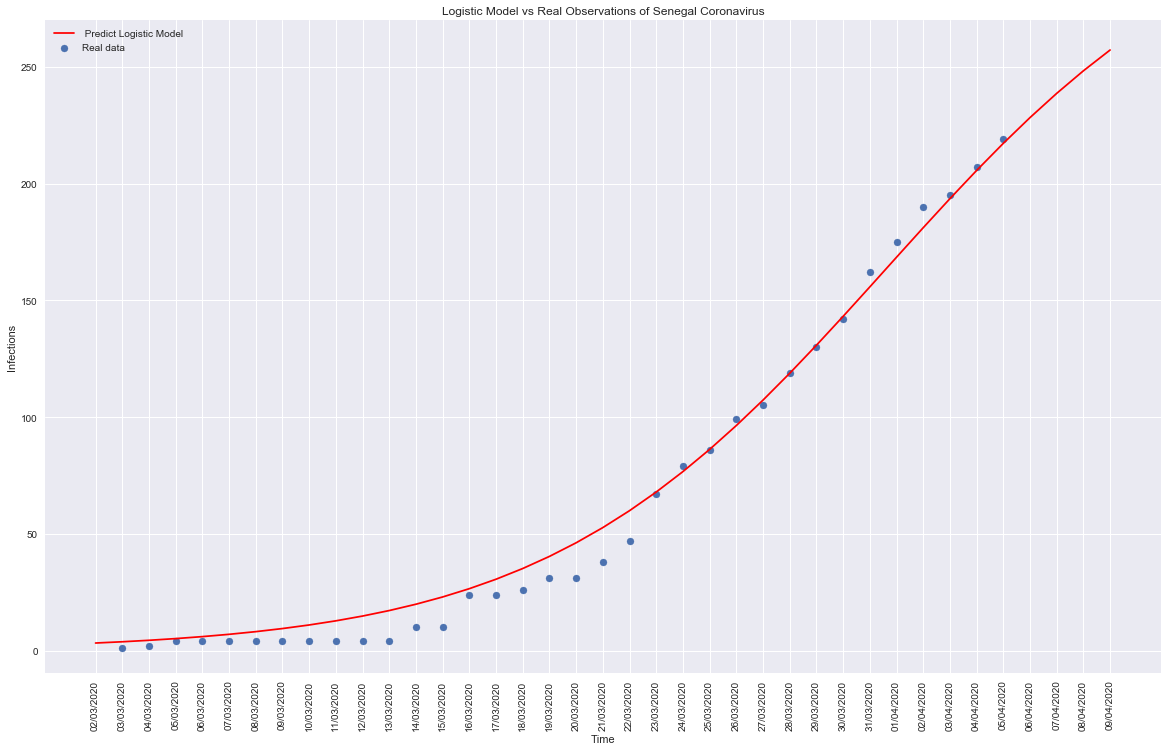

30.0
163.51597946947345
logistic future predictions:
          Date Predictions
34  05/04/2020     [217.0]
35  06/04/2020     [228.0]
36  07/04/2020     [239.0]
37  08/04/2020     [248.0]
38  09/04/2020     [257.0]


In [22]:
logistic_growth_model('Senegal', df, n=5, size = 3)

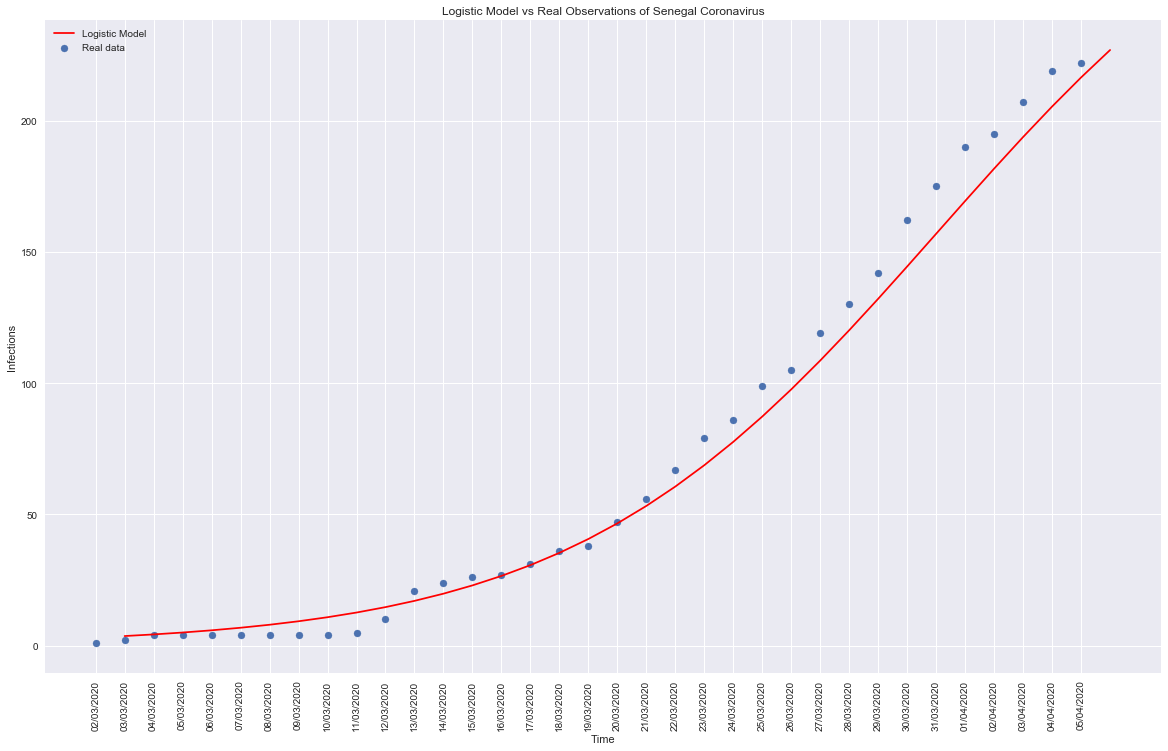

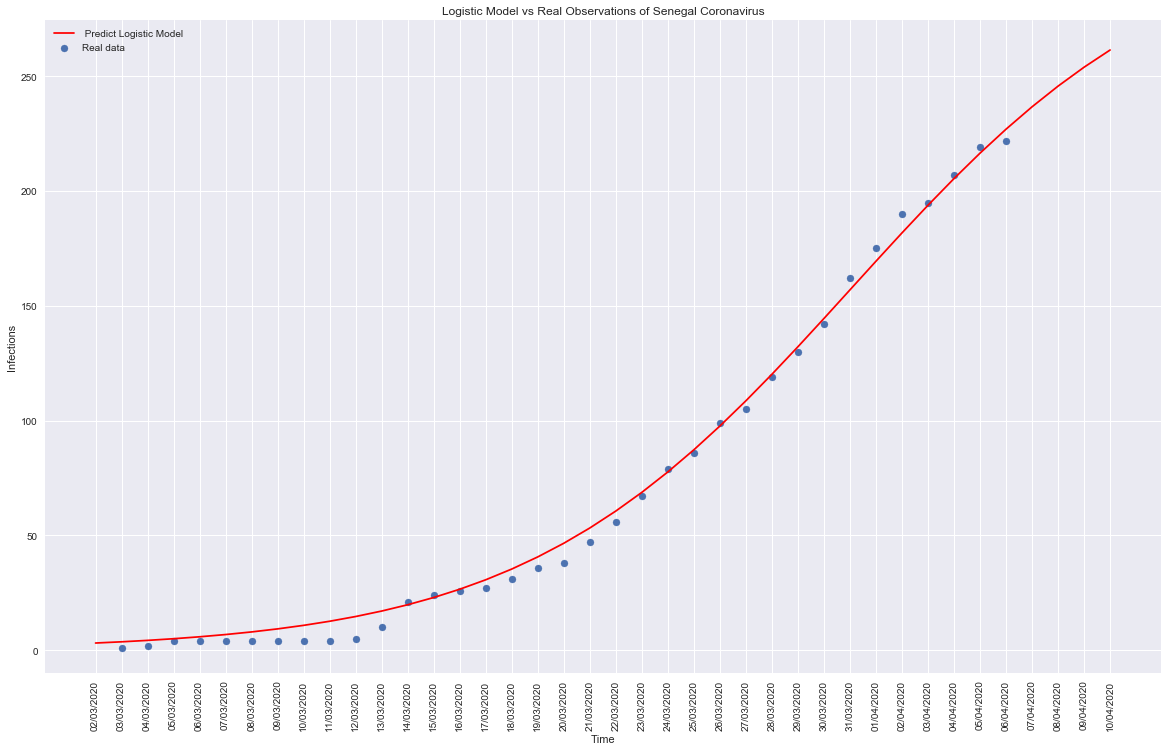

29.0
157.8309655872069
logistic future predictions:
          Date Predictions
35  06/04/2020     [227.0]
36  07/04/2020     [237.0]
37  08/04/2020     [246.0]
38  09/04/2020     [254.0]
39  10/04/2020     [261.0]


In [23]:
logistic_growth_model('Senegal', df_senegal, n=5, size = 3)

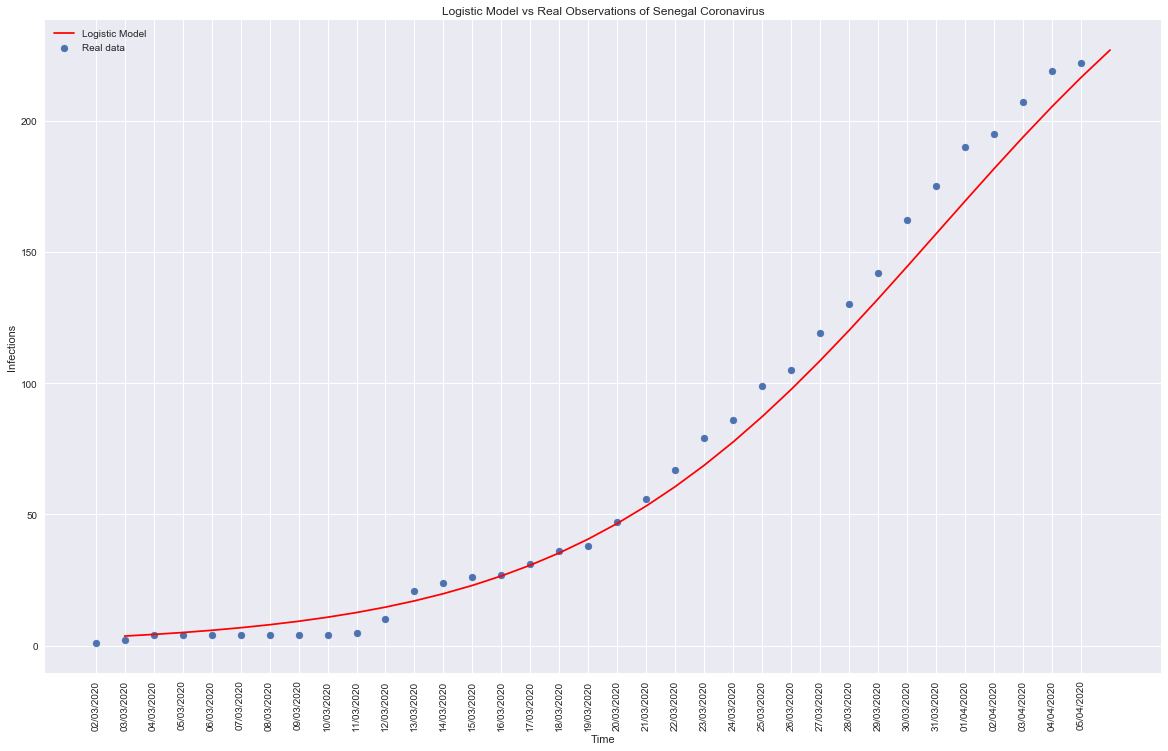

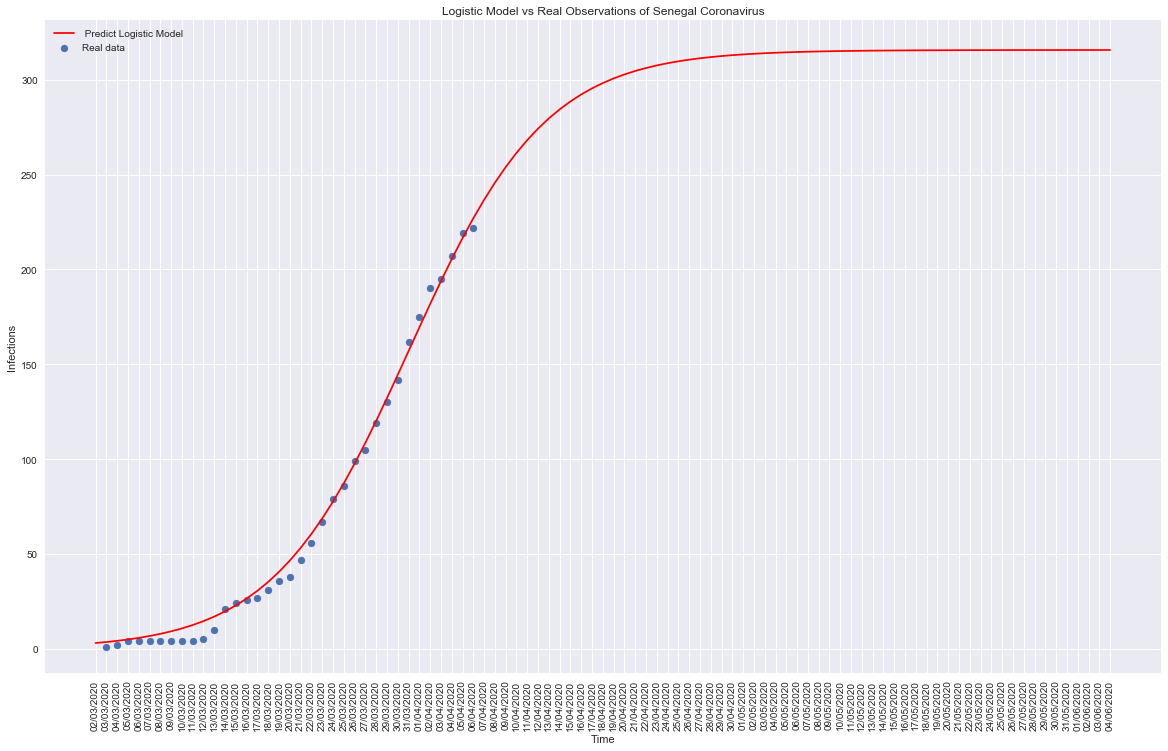

29.0
157.83076083088355
logistic future predictions:
          Date Predictions
35  06/04/2020     [227.0]
36  07/04/2020     [237.0]
37  08/04/2020     [246.0]
38  09/04/2020     [254.0]
39  10/04/2020     [261.0]
40  11/04/2020     [268.0]
41  12/04/2020     [274.0]
42  13/04/2020     [280.0]
43  14/04/2020     [284.0]
44  15/04/2020     [289.0]
45  16/04/2020     [292.0]
46  17/04/2020     [295.0]
47  18/04/2020     [298.0]
48  19/04/2020     [301.0]
49  20/04/2020     [303.0]
50  21/04/2020     [305.0]
51  22/04/2020     [306.0]
52  23/04/2020     [308.0]
53  24/04/2020     [309.0]
54  25/04/2020     [310.0]
55  26/04/2020     [311.0]
56  27/04/2020     [311.0]
57  28/04/2020     [312.0]
58  29/04/2020     [312.0]
59  30/04/2020     [313.0]
60  01/05/2020     [313.0]
61  02/05/2020     [314.0]
62  03/05/2020     [314.0]
63  04/05/2020     [314.0]
64  05/05/2020     [314.0]
65  06/05/2020     [315.0]
66  07/05/2020     [315.0]
67  08/05/2020     [315.0]
68  09/05/2020     [315.0]
69

In [24]:
logistic_growth_model('Senegal', df_senegal, n=60, size = 3)

# Modelisation par Prophet FB

In [25]:
from fbprophet import Prophet
df_senegal.head()
df_senegal_prophet=df_senegal[['Date','Daily_case']]
df_senegal_prophet
df_senegal_prophet.rename(columns={'Date': 'ds', 'Daily_case': 'y'}, inplace=True)
df_senegal_prophet.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,2020-03-02,1
1,2020-03-03,1
2,2020-03-04,2
3,2020-03-05,0
4,2020-03-06,0


In [26]:
# model Fitting
model = Prophet()
model.fit(df_senegal_prophet)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
# Making Future Predictions
future = model.make_future_dataframe(periods=24)
future.head()

,ds
0,2020-03-02
1,2020-03-03
2,2020-03-04
3,2020-03-05
4,2020-03-06


In [33]:
# forecasting
forcast = model.predict(future)
forcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-02,-0.773704,-3.163216,4.725960,-0.773704,-0.773704,1.711741,1.711741,1.711741,1.711741,1.711741,1.711741,0.0,0.0,0.0,0.938037
1,2020-03-03,-0.354807,-4.739684,3.295403,-0.354807,-0.354807,-0.505730,-0.505730,-0.505730,-0.505730,-0.505730,-0.505730,0.0,0.0,0.0,-0.860537
2,2020-03-04,0.064090,-2.768370,5.655573,0.064090,0.064090,1.274797,1.274797,1.274797,1.274797,1.274797,1.274797,0.0,0.0,0.0,1.338887
3,2020-03-05,0.482987,-6.745375,1.625825,0.482987,0.482987,-2.741524,-2.741524,-2.741524,-2.741524,-2.741524,-2.741524,0.0,0.0,0.0,-2.258537
4,2020-03-06,0.901884,-0.840731,7.336709,0.901884,0.901884,2.437420,2.437420,2.437420,2.437420,2.437420,2.437420,0.0,0.0,0.0,3.339305


In [34]:
forcast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-03-02,0.938037,-3.163216,4.725960
1,2020-03-03,-0.860537,-4.739684,3.295403
2,2020-03-04,1.338887,-2.768370,5.655573
3,2020-03-05,-2.258537,-6.745375,1.625825
4,2020-03-06,3.339305,-0.840731,7.336709
5,2020-03-07,1.141133,-2.876007,5.340116
6,2020-03-08,-0.257379,-4.739776,3.824124
7,2020-03-09,3.870317,-0.044259,7.700148
8,2020-03-10,2.071743,-2.214197,6.131254
9,2020-03-11,4.271167,0.245476,8.266657


In [35]:
forcast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
54,2020-04-25,21.667091,17.165773,25.484239
55,2020-04-26,20.268579,16.283112,24.243655
56,2020-04-27,24.396275,20.232703,28.568891
57,2020-04-28,22.597701,18.674233,26.645068
58,2020-04-29,24.797125,20.759851,28.884426


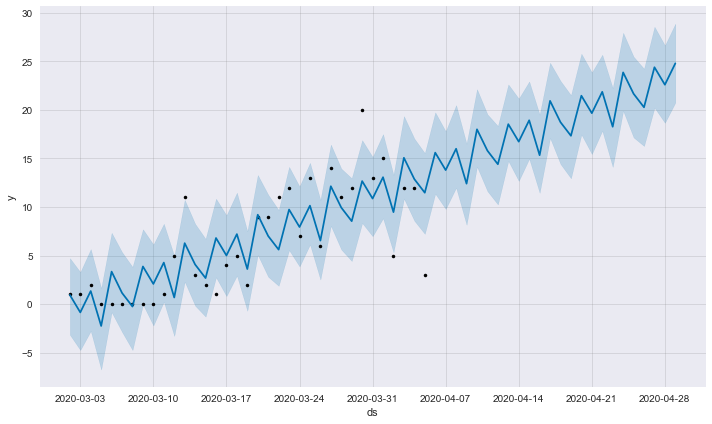

In [36]:
# plotting
plot1 = model.plot(forcast)

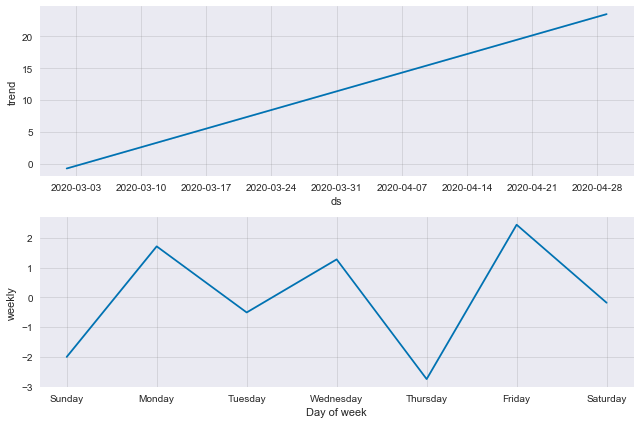

In [37]:
plot2= model.plot_components(forcast)

### Cross Validation
 
Next let’s measure the forecast error using the historical data. We’ll do this by comparing the predicted values with the actual values. In order to perform this operation we select cut of points in the history of the data and fit the model with data upto that cut off point. Afterwards we compare the actual values to the predicted values. The cross_validation method allows us to do this in Prophet. This method take the following parameters as explained below:

1. horizon the forecast horizon
2. initial the size of the initial training period
3. period the spacing between cutoff dates
The output of the cross_validation method is a dataframe containing y the true values and yhat the predicted values. We’ll use this dataframe to compute the prediction errors.

In [38]:
from fbprophet.diagnostics import cross_validation
df_senegal_prophet_cv = cross_validation(model, initial='1 days', period='7 days', horizon = '14 days')
df_senegal_prophet_cv.head()


INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-03-08 00:00:00 and 2020-03-22 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-09,4.650535,4.582358,4.721911,0,2020-03-08
1,2020-03-10,5.032119,4.770766,5.280836,0,2020-03-08
2,2020-03-11,6.442931,5.911470,6.939629,1,2020-03-08
3,2020-03-12,4.855205,3.957189,5.659172,5,2020-03-08
4,2020-03-13,4.796340,3.554135,5.982132,11,2020-03-08


In [39]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_senegal_prophet_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,2 days,12.174532,3.489202,2.541954,0.301523,0.500000
1,3 days,15.927470,3.990923,3.178945,0.234587,0.416667
2,4 days,10.138622,3.184120,2.453879,0.329436,0.583333
3,5 days,12.562845,3.544410,2.685755,0.355171,0.666667
4,6 days,8.315126,2.883596,2.495048,0.276628,0.416667


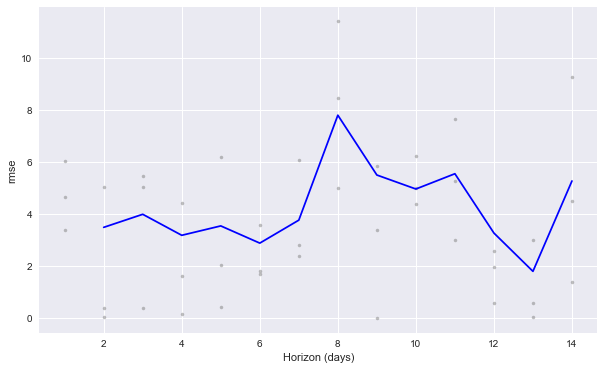

In [40]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_senegal_prophet_cv, metric='rmse')

# Deep learning  Long Short-Term Memory.

In [43]:
training_set = df_senegal_prophet.iloc[:, 1:2].values
training_set

array([[ 1],
       [ 1],
       [ 2],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 5],
       [11],
       [ 3],
       [ 2],
       [ 1],
       [ 4],
       [ 5],
       [ 2],
       [ 9],
       [ 9],
       [11],
       [12],
       [ 7],
       [13],
       [ 6],
       [14],
       [11],
       [12],
       [20],
       [13],
       [15],
       [ 5],
       [12],
       [12],
       [ 3]])